In [1]:
import numpy as np
import pandas as pd

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TemporalModel from the Nanduri paper
tm = ec2b.TemporalModel(model='Nanduri')

# input amplitude values and expected output
exp_thresh = 30
all_amps = np.array([1.25, 1.5, 2, 4, 6]) * exp_thresh
out_amps = np.array([10, 15, 18, 19, 19])

# input frequency values and expected output
all_freqs = np.array([13, 20, 27, 40, 80, 120])
out_freqs = np.array([7.3, 10, 13, 19, 34, 51])

In [3]:
# Pulse train used in Nanduri et al. (2012)
def get_pulse_train(freq, ampl, pulse_dur=0.45/1000, dur=0.5, tsample=5e-6):
    return e2cm.Psycho2Pulsetrain(freq=freq, dur=dur, 
                                  pulse_dur=pulse_dur, interphase_dur=0,
                                  delay=0.,
                                  tsample=tsample, current_amplitude=ampl, 
                                  pulsetype='cathodicfirst')

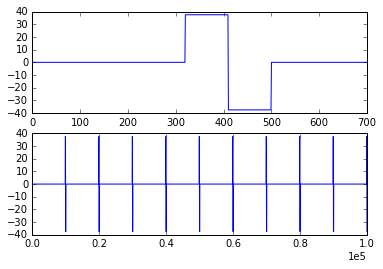

In [4]:
pulse_train = get_pulse_train(20, all_amps[0])
plt.subplot(211)
plt.plot(pulse_train.data[9500:10200])
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(pulse_train.data)

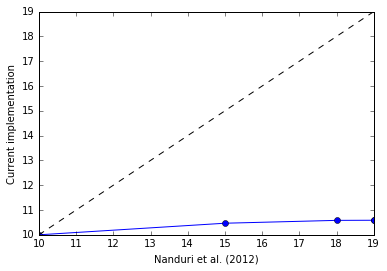

In [5]:
# Run the model on these values and compare model output vs. Nanduri data.
# Amplitude is way off...
B = []
for ampl in all_amps:
    R4 = tm.model_cascade(get_pulse_train(20, ampl), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

# Perhaps values are just off by some scaling factor.
# Therefore, normalize so first value is B=10...
scale = B[0] / out_amps[0]

plt.plot(out_amps, B / scale, 'o-')
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri et al. (2012)')
plt.ylabel('Current implementation')

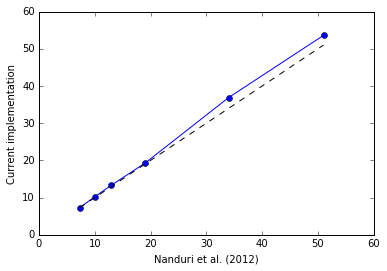

In [6]:
# Run the model on these values and compare model output vs. Nanduri data.
# Frequency plot is a good match.
B = []
for freq in all_freqs:
    R4 = tm.model_cascade(get_pulse_train(freq, 1.25), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

scale = B[0] / out_freqs[0]

plt.plot(out_freqs, B / scale, 'o-')
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri et al. (2012)')
plt.ylabel('Current implementation')

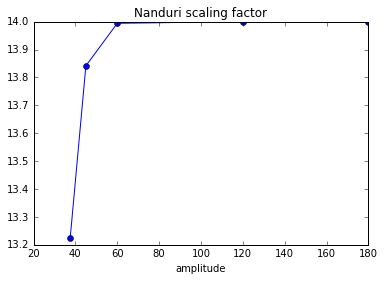

In [7]:
old_scale = []
for ampl in all_amps:
    pt = get_pulse_train(20, ampl)
    fr = tm.fast_response(pt.data, dojit=True)
    ca = tm.charge_accumulation(pt.data)
    R2 = fr - ca
    old_scale.append(tm.asymptote / (1 + np.exp(-(R2.max() - tm.shift) / tm.slope)))
old_scale = np.array(old_scale)

plt.plot(all_amps, old_scale, 'o-')
plt.xlabel('amplitude')
plt.title('Nanduri scaling factor')

In [8]:
# Let's replace the stationary_nonlinearity step with a simple
# scaling factor that can be set via `asymptote`.
class NewTemporalModel(ec2b.TemporalModel):
    def stationary_nonlinearity(self, b3):
        return np.maximum(0, b3) ** self.beta

In [9]:
ntm = NewTemporalModel(model='Nanduri')

In [10]:
# Now, instead of the logistic function that is currently implemented:
# What scaling factor would be required (as a function of amplitude) 
# to make the model output match the Nanduri amplitude data?

# Search a wide range of scaling factors
scales = np.linspace(1, 3, 500)

all_err = []
all_scale = []
all_R2 = []
for ampl, tb in zip(all_amps, out_amps):
    pt = get_pulse_train(20, ampl)
    
    # calculate the MSE for a given scaling factor
    err = []
    R2 = []
    for s in scales:
        ntm.beta = s
        R1 = ntm.fast_response(pt.data, dojit=True)
        ca = ntm.charge_accumulation(pt.data)
        diff = R1 - ca
        R2.append(diff.max())
        
        R4 = ntm.slow_response(ntm.stationary_nonlinearity(diff))
        err.append((R4.max() - tb)**2)
        
    # find the scaling factor that gives the smallest error
    all_err.append(min(err))
    all_scale.append(scales[np.argmin(err)])
    all_R2.append(R2[np.argmin(err)])
    
all_err = np.array(all_err)
all_scale = np.array(all_scale)
all_R2 = np.array(all_R2)

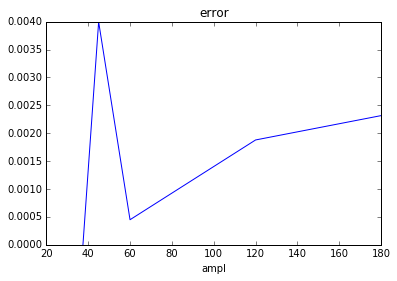

In [11]:
plt.plot(all_amps, all_err)
plt.title('error')
plt.xlabel('ampl')

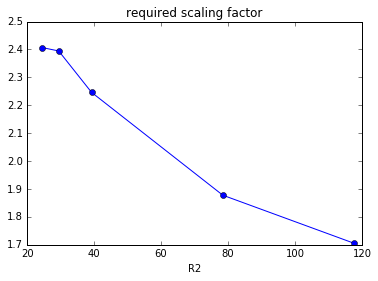

In [12]:
# Looks more like a Poisson function than a logistic function...
plt.plot(all_R2, all_scale, 'o-')
plt.xlabel('R2')
plt.title('required scaling factor')

In [13]:
# try to fit the curve with a decaying exponential
def expdecay(x, n0, lam, shift):
    return np.minimum(2.4, n0 * np.exp(-lam*x) + shift)

In [14]:
x = all_R2 / 200

n0 = np.linspace(1, 2, 100)
lam = np.linspace(2, 4, 100)
shi = np.linspace(1, 2, 100)

best_err = np.inf
best_n0 = -1
best_lam = -1
best_s = 0
for n in n0:
    for l in lam:
        for s in shi:
            err = np.sum((expdecay(x, n, l, s) - all_scale) ** 2)
            if err < best_err:
                best_err = err
                best_n0 = n
                best_lam = l
                best_s = s

[best_err, best_n0, best_lam, best_s]

[5.2065148920592482e-05,
 1.4848484848484849,
 3.8989898989898992,
 1.5555555555555556]

(1.5, 2.5)

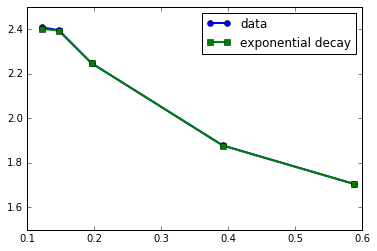

In [15]:
plt.plot(x, all_scale, '-o', linewidth=2, label='data')
plt.plot(x, expdecay(x, best_n0, best_lam, best_s), '-s', linewidth=2, label='exponential decay')
plt.legend()
plt.ylim(1.5, 2.5)

In [16]:
# Case in point: If we apply these scaling factors correctly as a function of amplitude,
# our new implementation should match the Nanduri data
class ExtendedHorsagerModel(ec2b.TemporalModel):
    def stationary_nonlinearity(self, b3):
        beta = best_n0 * np.exp(-best_lam * b3.max() / 200) + best_s
        return np.maximum(0, b3) ** np.minimum(2.4, beta)

horsager = ExtendedHorsagerModel(model='Nanduri')

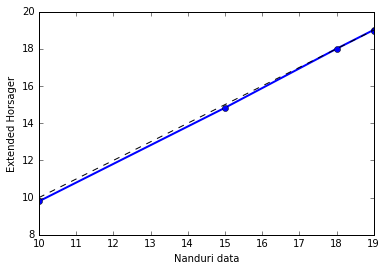

In [17]:
B = []
for ampl,s in zip(all_amps, all_scale):
    R4 = horsager.model_cascade(get_pulse_train(20, ampl), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

plt.plot(out_amps, B, '-o', linewidth=2)
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri data')
plt.ylabel('Extended Horsager')

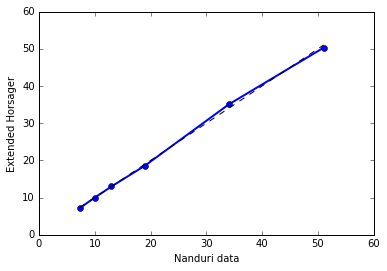

In [18]:
B = []
for freq in all_freqs:
    ntm.beta = all_scale[0]
    R4 = ntm.model_cascade(get_pulse_train(freq, all_amps[0]), dojit=True)
    B.append(R4.data.max())

plt.plot(out_freqs, B, '-o', linewidth=2)
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri data')
plt.ylabel('Extended Horsager')